In [1]:
import (
    "fmt"
    "math"
    "math/rand"
    "gonum.org/v1/gonum/mat"
    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/plotutil"
    "bytes"
    "gonum.org/v1/plot/vg"
    "gonum.org/v1/plot/vg/draw"
)

In [2]:
type RandomMotionParameters struct {
    motionNoise float64
    measurementNoise float64
    initialState *mat.VecDense
}

In [3]:
func generateData(pointCount int, parameters RandomMotionParameters,
    timeDelta float64) ([]mat.VecDense, []mat.VecDense) {
    state := parameters.initialState
    var measurement *mat.VecDense
    var measurements []mat.VecDense
    var states []mat.VecDense
    var acceleration float64
    for i := 0; i < pointCount; i++ {
        acceleration = rand.NormFloat64() * parameters.motionNoise
        state = mat.NewVecDense(2, []float64{state.AtVec(0) + state.AtVec(1) * timeDelta + acceleration * timeDelta * timeDelta / 2,
        state.AtVec(1) + acceleration * timeDelta})
        measurement = mat.NewVecDense(1, []float64{state.AtVec(0) + rand.NormFloat64() * parameters.measurementNoise})
        measurements = append(measurements, *measurement)
        states = append(states, *state)
    }
    return measurements, states
}

In [4]:
func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(8*vg.Inch, 4*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }
    Display(display.PNG(buf.Bytes()))
}

# Generate data

In [5]:
timeDelta := 0.1
pointCount := 500
motionNoise := 1.
measurementNoise := 1.

In [6]:
times := make([]float64, pointCount)
for i := 0; i < pointCount; i++ {
    times[i] = float64(i) * timeDelta
}

parameters := RandomMotionParameters{1, 1, mat.NewVecDense(2, []float64{0, 0})}

measurements, states := generateData(pointCount, parameters, timeDelta)

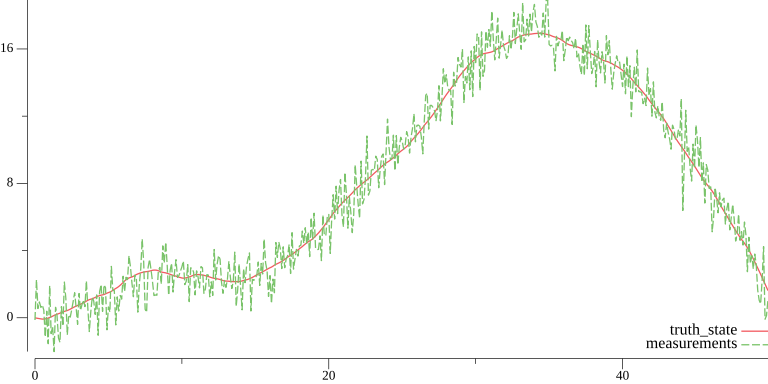

In [7]:
p := plot.New()

var stateXYs plotter.XYs
var measurementXYs plotter.XYs

for i, _ := range(states) {
    stateXYs = append(stateXYs, plotter.XY{times[i], states[i].AtVec(0)})
    measurementXYs = append(measurementXYs, plotter.XY{times[i], measurements[i].AtVec(0)})
}

plotutil.AddLines(p, "truth_state", stateXYs,"measurements", measurementXYs)
displayPlot(p)

# Kalman filter

In [8]:
import "github.com/MisterMap/kalman-go/kalman"
import "time"

In [9]:
filter := kalman.MakeSimpleKalmanFilter(timeDelta, motionNoise, measurementNoise)

In [10]:
initialState := kalman.State{State: mat.NewVecDense(2, []float64{0, 0}),
                             Covariance: mat.NewDense(2, 2, []float64{0.1, 0, 0, 0.1})}

In [11]:
result := filter.FilterStates(measurements, initialState)

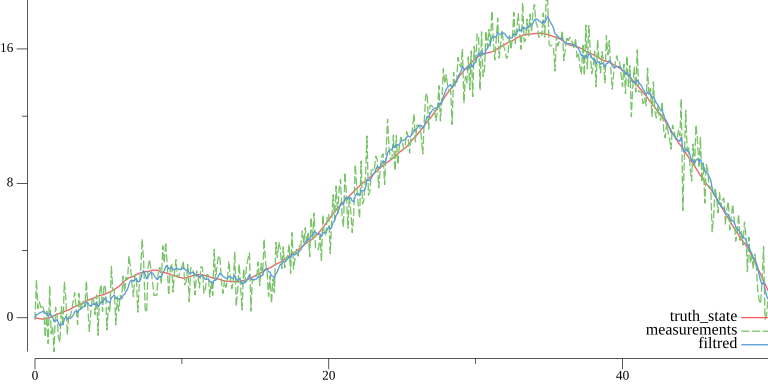

In [12]:
p := plot.New()

var stateXYs plotter.XYs
var measurementXYs plotter.XYs
var filtredXYs plotter.XYs

for i, _ := range(states) {
    stateXYs = append(stateXYs, plotter.XY{times[i], states[i].AtVec(0)})
    measurementXYs = append(measurementXYs, plotter.XY{times[i], measurements[i].AtVec(0)})
    filtredXYs = append(filtredXYs, plotter.XY{times[i], result[i].State.AtVec(0)})
}

plotutil.DefaultDashes[2] = []vg.Length{}

plotutil.AddLines(p, 
                  "truth_state", stateXYs,
                  "measurements", measurementXYs,
                  "filtred", filtredXYs)
displayPlot(p)

## Benchmark

In [13]:
start := time.Now()
n := 1000
// n := 1
for i := 0; i < n; i++ {
    result := filter.FilterStates(measurements, initialState)
} 
t := time.Now()
t.Sub(start)

3.153558655s